<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/Food_Extraction_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hypopt

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; 
 
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
 
# Importing hypopt library for grid search
from hypopt import GridSearch
 
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')

In [5]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

Streaming output truncated to the last 5000 lines.
  inflating: train_set/train_set/train_55.jpg  
  inflating: train_set/train_set/train_550.jpg  
  inflating: train_set/train_set/train_5500.jpg  
  inflating: train_set/train_set/train_5501.jpg  
  inflating: train_set/train_set/train_5502.jpg  
  inflating: train_set/train_set/train_5503.jpg  
  inflating: train_set/train_set/train_5504.jpg  
  inflating: train_set/train_set/train_5505.jpg  
  inflating: train_set/train_set/train_5506.jpg  
  inflating: train_set/train_set/train_5507.jpg  
  inflating: train_set/train_set/train_5508.jpg  
  inflating: train_set/train_set/train_5509.jpg  
  inflating: train_set/train_set/train_551.jpg  
  inflating: train_set/train_set/train_5510.jpg  
  inflating: train_set/train_set/train_5511.jpg  
  inflating: train_set/train_set/train_5512.jpg  
  inflating: train_set/train_set/train_5513.jpg  
  inflating: train_set/train_set/train_5514.jpg  
  inflating: train_set/train_set/train_5515.jpg  
  i

In [46]:
data = [os.path.join("data/train_set/train_set",img) for img in os.listdir("data/train_set/train_set")]

In [47]:
print(len(data))
data[0:5]

30612


['data/train_set/train_set/train_19842.jpg',
 'data/train_set/train_set/train_6882.jpg',
 'data/train_set/train_set/train_12677.jpg',
 'data/train_set/train_set/train_7920.jpg',
 'data/train_set/train_set/train_6396.jpg']

In [48]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('data/train_labels.csv')
path = 'data/train_set/train_set/'

X = path+df.img_name.values
y = df.label.values - 1
print(X)
print(y)

['data/train_set/train_set/train_1.jpg'
 'data/train_set/train_set/train_2.jpg'
 'data/train_set/train_set/train_3.jpg' ...
 'data/train_set/train_set/train_30610.jpg'
 'data/train_set/train_set/train_30611.jpg'
 'data/train_set/train_set/train_30612.jpg']
[20 28 16 ...  5 20 23]


In [49]:
print(min(y),max(y))

0 79


In [50]:
from sklearn.model_selection import train_test_split

train, test, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

train, val, train_y, val_y = train_test_split(train, train_y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [51]:
len(train),len(val),len(test)

(18366, 6123, 6123)

In [52]:
len(test)/len(X)

0.20001960015680126

In [53]:
train_y = train_y.tolist()
train_y[0:10]

[33, 57, 23, 46, 70, 24, 29, 56, 74, 3]

In [54]:
train[0:10]

array(['data/train_set/train_set/train_489.jpg',
       'data/train_set/train_set/train_23183.jpg',
       'data/train_set/train_set/train_25020.jpg',
       'data/train_set/train_set/train_14050.jpg',
       'data/train_set/train_set/train_27036.jpg',
       'data/train_set/train_set/train_2367.jpg',
       'data/train_set/train_set/train_23795.jpg',
       'data/train_set/train_set/train_30483.jpg',
       'data/train_set/train_set/train_29631.jpg',
       'data/train_set/train_set/train_17237.jpg'], dtype=object)

In [55]:
num_classes = 80
y_train = np_utils.to_categorical(train_y, num_classes)
y_val = np_utils.to_categorical(val_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)

In [56]:
train_y[0:10]

[33, 57, 23, 46, 70, 24, 29, 56, 74, 3]

In [57]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Training data available in 80 classes
[289, 268, 243, 218, 195, 196, 257, 248, 296, 263, 233, 246, 186, 276, 292, 241, 273, 205, 162, 20, 201, 233, 278, 240, 194, 238, 204, 175, 277, 274, 194, 189, 188, 217, 203, 240, 289, 302, 234, 158, 236, 157, 265, 224, 236, 248, 206, 237, 263, 245, 177, 266, 272, 198, 171, 240, 301, 250, 172, 252, 294, 244, 211, 204, 273, 185, 153, 220, 225, 230, 305, 288, 239, 278, 210, 190, 229, 159, 262, 216]


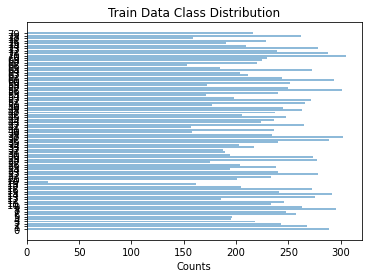

In [58]:
print("Training data available in 80 classes")
print([train_y.count(i) for i in range(0,num_classes)])

food_classes = list(range(80)) 
# food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
#            'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
 
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,num_classes)]
 
plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')
plt.show()

In [59]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

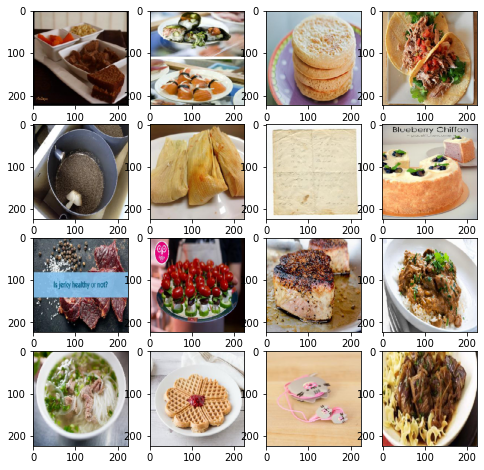

In [60]:
show_imgs(train)